In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time 
from scipy import signal

import serial

import funciones_MPU6050 as MPU6050

# Filtro de Kalman - Medicion Angulo

## Definimos las reglas del modelo 

Al estado lo vamos a definir como:

[$\theta (º) , \omega (º/seg.)$]

El angulo viene dado por el agulo actual mas la integral de la velocidad en el delta de tiempo del sampleo. La velocidad no deberia cambiar segun la información que tenemos.

In [2]:
delta_T = 0.05

In [3]:
NUM_STATES = 2

# Definimos la operacion como:
# o(t) = o(t-1) + delta_T * w(t-1) 
# w(t) = w(t-1) 
# En forma matricial
F = np.array([[1,delta_T],[0,1]])

# Definimos el error del modelo
MODEL_STD_ANG = 0.00000001 # 
MODEL_STD_VEL = 0.00000001 # 
P_std = np.array([MODEL_STD_ANG,MODEL_STD_VEL], np.double)
Q = np.eye(NUM_STATES,NUM_STATES)*np.power(P_std,2)


## Definimos la medicion del estado

Vamos a medir agulo con dos acelerometros y velocidad angular con un giroscopo.
 
 [$\theta_X (º), \theta_Y (º) , \omega_Z (º/seg.)$]

In [4]:
NUM_MEDICIONES = 3

# Matriz para pasar de la medicon al vector de estados
H = np.array([[1 , 0],[1 , 0],[0 , 1]]) 

# Obtenemos datos del hardware

### Medimos un estado inicial

Para poder obtener el primer estado vamos a usar una medición estatica y como sabemos que cerca de cero el eje Y mide mejor, vamos a usar solo la iformación de este eje.

In [6]:
# Abrimos el puerto serie
ser = serial.Serial('/dev/ttyUSB0', timeout=1, baudrate=9600)

time.sleep(1)

# Pedimos datos
medicion, mean_time_sample = MPU6050.get_datos_estatico(ser, Ndatos = 50)

# Cerramos el puerto
ser.close()

# Parsemos la información
PROM_SIZE_ACEL_def = 15
PROM_SIZE_GYRO_def = 15

estatic_med_signals, estatic_med_std, estatic_med_rel_err = MPU6050.get_signals(medicion, PROM_SIZE_ACEL = PROM_SIZE_ACEL_def)

/home/rawthil/Documents/Medidas I - Catedra/Presentaciones/en proceso/Kalman/Python/funciones_MPU6050.py:72: RuntimeWarning: Mean of empty slice.
  mean_time_sample = np.array(time_list).mean()
/home/rawthil/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rawthil/Documents/Medidas I - Catedra/Presentaciones/en proceso/Kalman/Python/funciones_MPU6050.py:257: RuntimeWarning: divide by zero encountered in true_divide
  out_rel_err[0,:] = np.divide(acel2deg(out_std[0,:]),acel2deg(out_signals[0,:]))
/home/rawthil/Documents/Medidas I - Catedra/Presentaciones/en proceso/Kalman/Python/funciones_MPU6050.py:271: RuntimeWarning: divide by zero encountered in true_divide
  out_rel_err[1,:] = np.divide(acel2deg(out_std[1,:]),acel2deg(out_signals[1,:]))
/home/rawthil/Documents/Medidas I - Catedra/Presentaciones/en proceso/Kalman/Python/funciones_MPU6050.py:298: RuntimeWarning: divide 

In [7]:
INITIAL_VAL_ANG = estatic_med_signals[1,:].mean()
INITIAL_VAL_VEL = estatic_med_signals[2,:].mean()
INITIAL_STD_ANG = estatic_med_std[1,:].mean()/np.sqrt(len(estatic_med_std[1,:]))
INITIAL_STD_VEL = estatic_med_std[2,:].mean()/np.sqrt(len(estatic_med_std[2,:]))

x = np.array([INITIAL_VAL_ANG, INITIAL_VAL_VEL], np.double)
x_ini = np.reshape(x, [NUM_STATES,1])

# Desvios standard de cada variable (esperados)
P_std = np.array([INITIAL_STD_ANG,INITIAL_STD_VEL], np.double)
# Armamos la matriz de covarianza inicial
P_ini = np.eye(NUM_STATES,NUM_STATES)*np.power(P_std,2)

print("Estado inicial:")
print(x_ini)
print("Matriz covarianza inicial:")
print(P_ini)

Estado inicial:
[[16.25829626]
 [ 0.38732824]]
Matriz covarianza inicial:
[[0.05543783 0.        ]
 [0.         2.66666773]]


### Ploteo el estado inicial

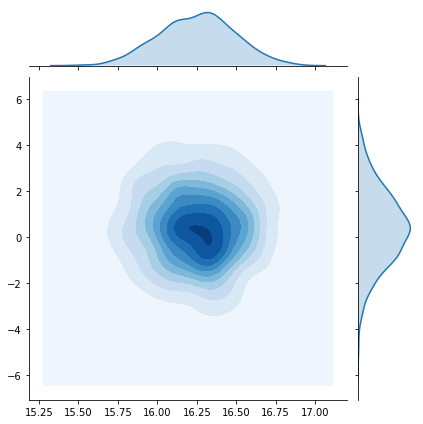

In [8]:
plot_samples=1000

sample_aux = np.random.multivariate_normal(np.squeeze(x_ini),P_ini, size=plot_samples)

sns.jointplot(sample_aux[:,0],sample_aux[:,1] , cmap="Blues", kind="kde")


### Medimos una vuelta

In [9]:
# Abrimos el puerto serie
ser = serial.Serial('/dev/ttyUSB0', timeout=1, baudrate=9600)

time.sleep(1)

# Pedimos datos
medicion, mean_time_sample = MPU6050.get_datos(ser, 'R')

# Cerramos el puerto
ser.close()

## Ploteamos la medición cruda

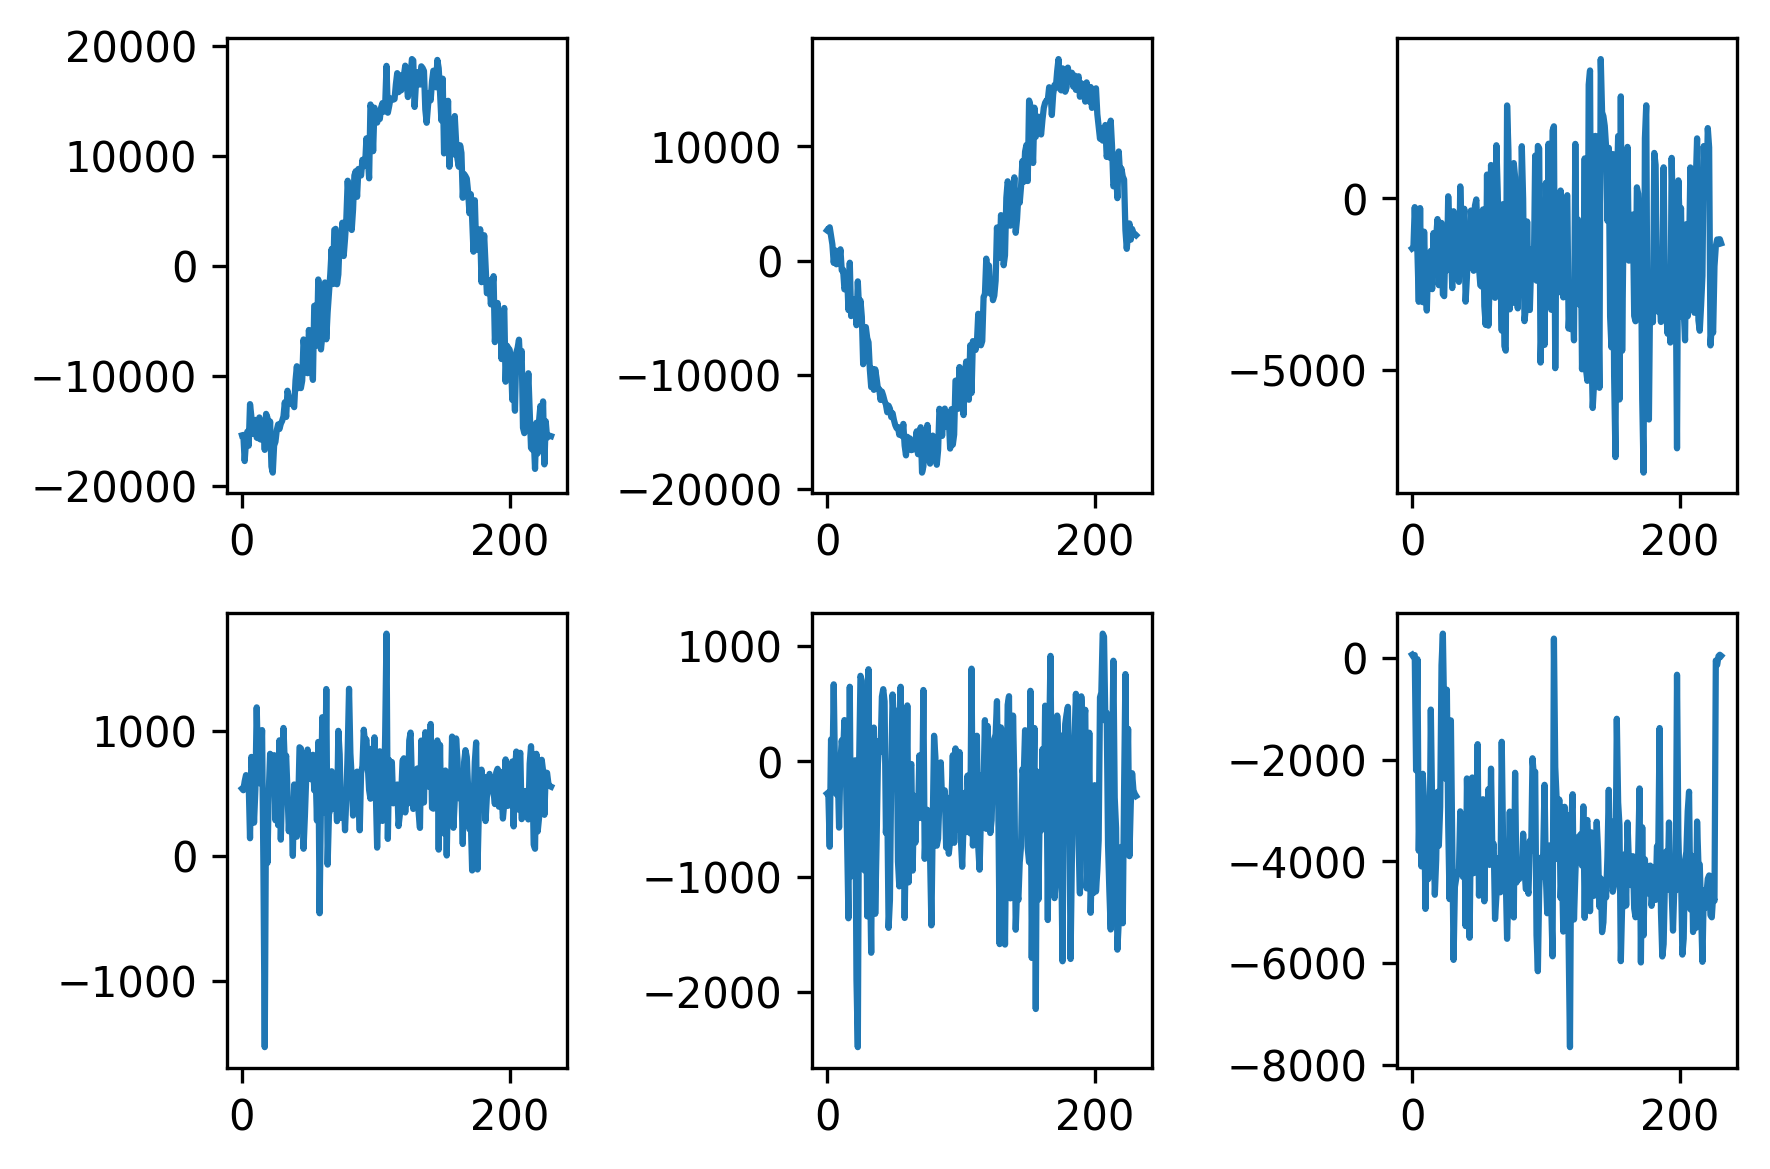

In [10]:
plt.figure(dpi=300)
ax = plt.subplot(2,3,1)
ax.plot(medicion[:,MPU6050.A_X])
ax = plt.subplot(2,3,2)
ax.plot(medicion[:,MPU6050.A_Y])
ax = plt.subplot(2,3,3)
ax.plot(medicion[:,MPU6050.A_Z])

ax = plt.subplot(2,3,4)
ax.plot(medicion[:,MPU6050.G_X])
ax = plt.subplot(2,3,5)
ax.plot(medicion[:,MPU6050.G_Y])
ax = plt.subplot(2,3,6)
ax.plot(medicion[:,MPU6050.G_Z])

plt.tight_layout()
#plt.axis('off')
plt.show()

## Procesamos las señales

/home/rawthil/Documents/Medidas I - Catedra/Presentaciones/en proceso/Kalman/Python/funciones_MPU6050.py:271: RuntimeWarning: divide by zero encountered in true_divide
  out_rel_err[1,:] = np.divide(acel2deg(out_std[1,:]),acel2deg(out_signals[1,:]))


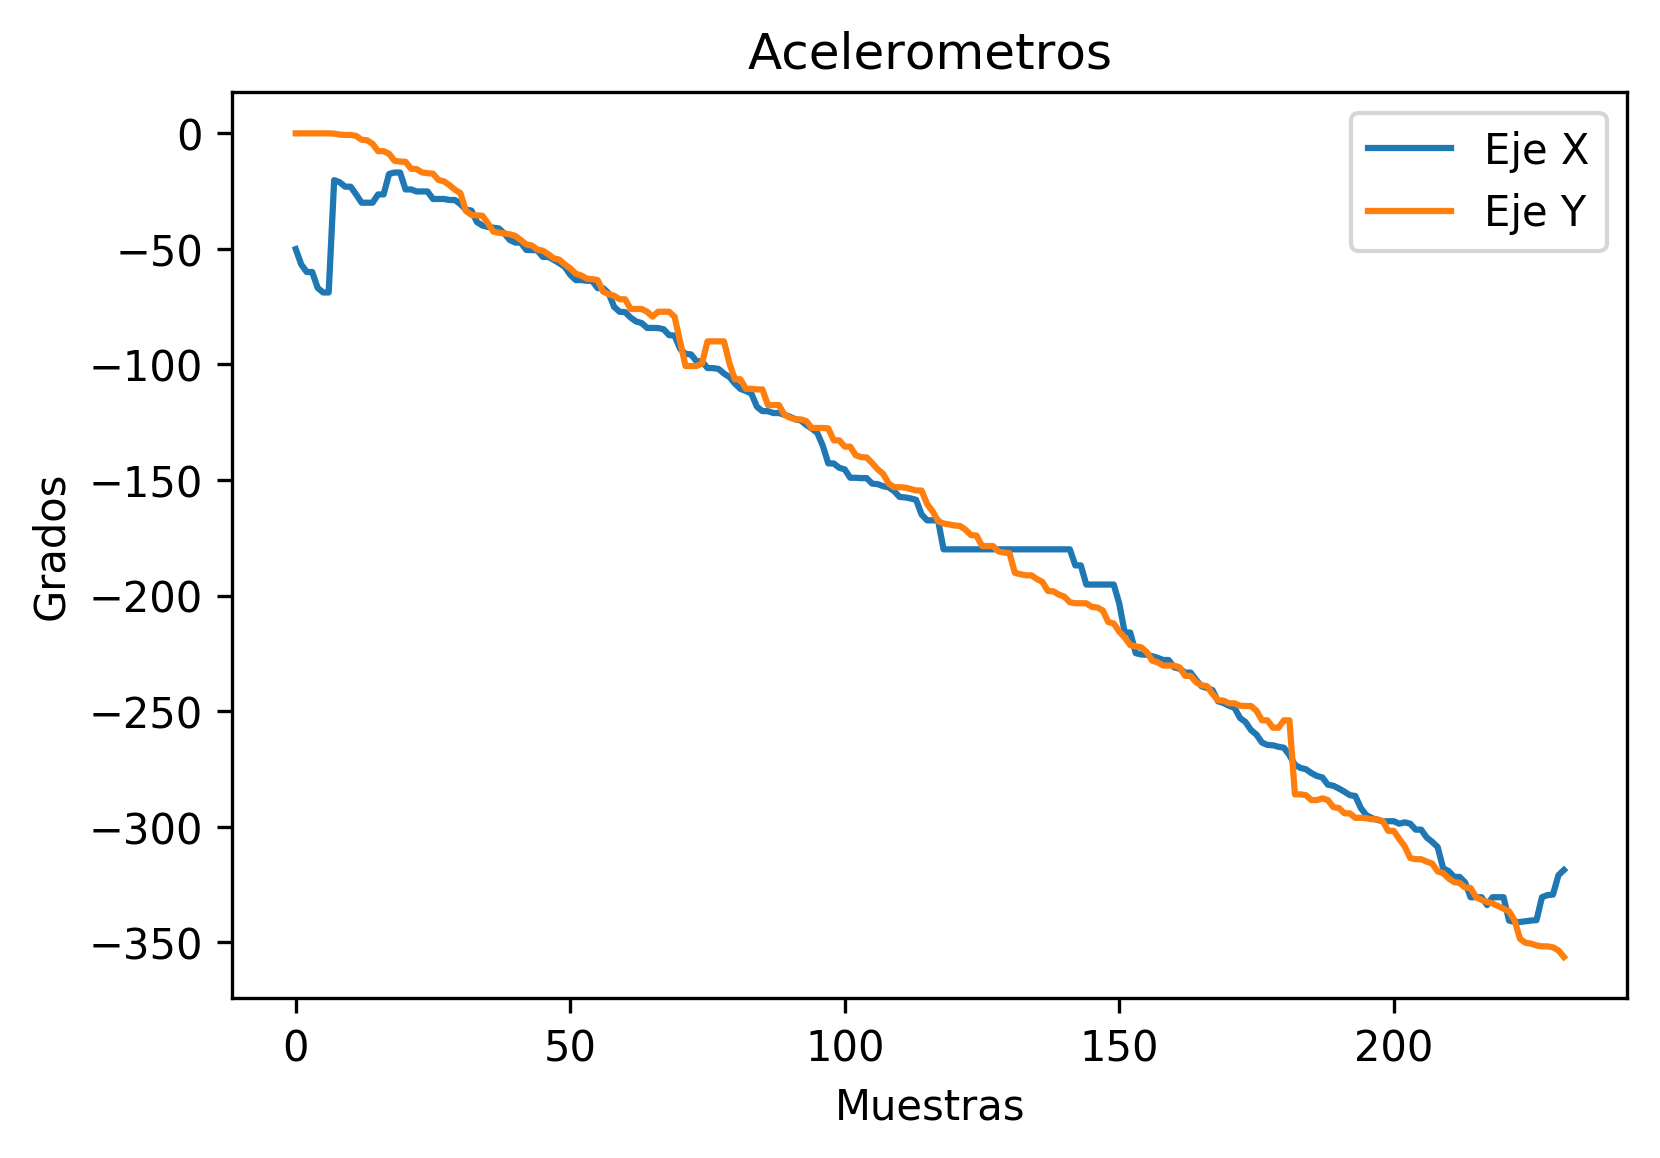

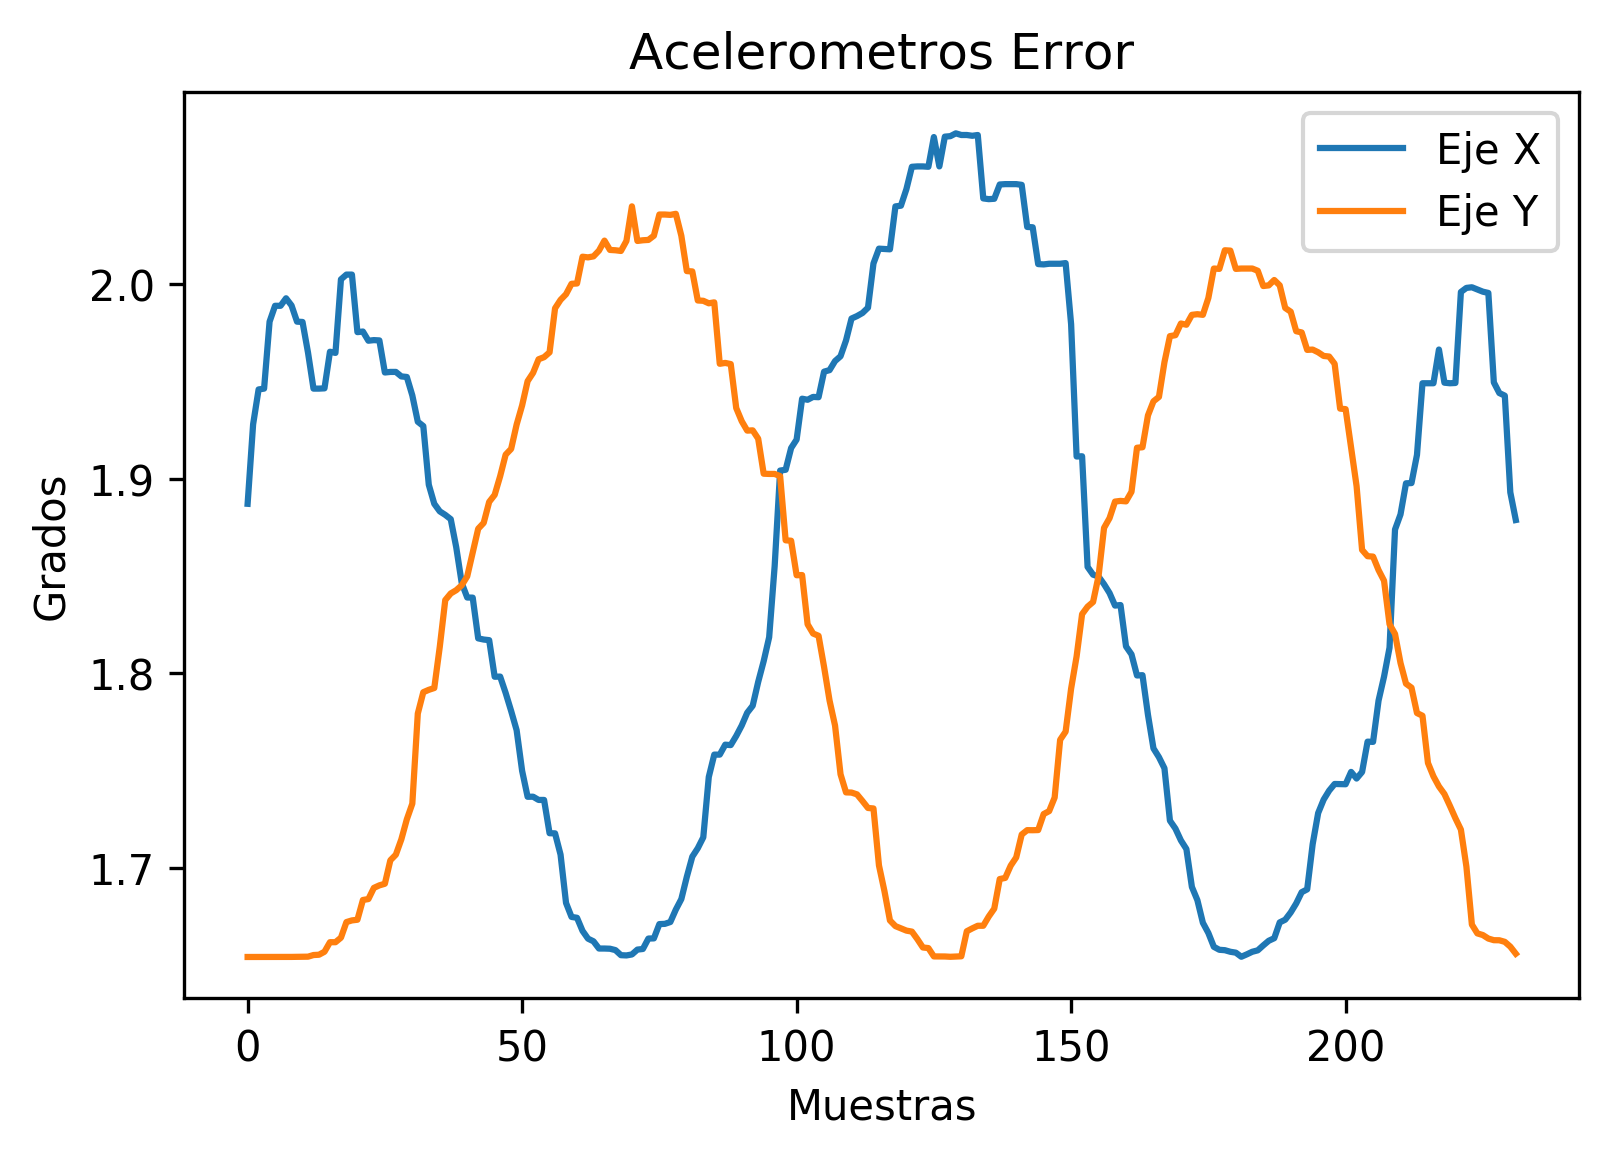

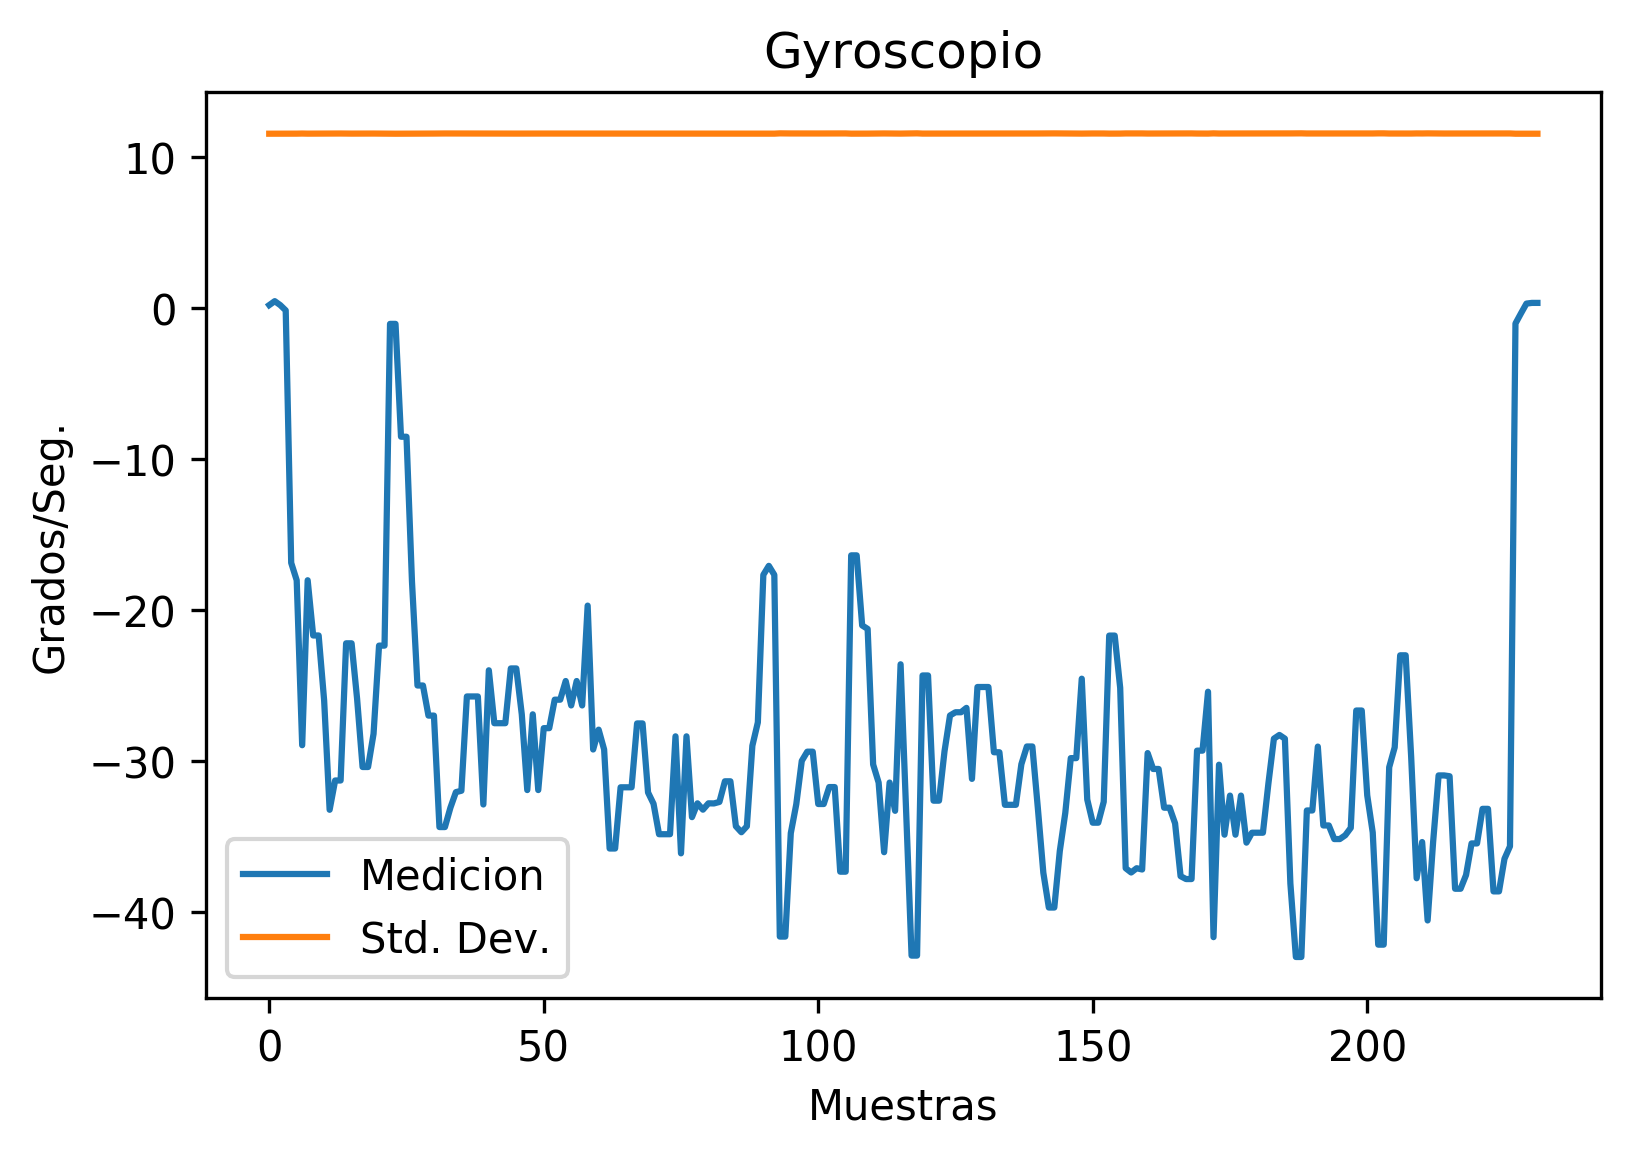

In [11]:

med_signals, med_std, med_rel_err = MPU6050.get_signals(medicion, PROM_SIZE_ACEL = PROM_SIZE_ACEL_def)


plt.figure(dpi=300)
plt.plot(med_signals[0,:])
plt.plot(med_signals[1,:])
plt.title('Acelerometros')
plt.legend(['Eje X', 'Eje Y'])
plt.ylabel('Grados')
plt.xlabel('Muestras')
plt.show()

plt.figure(dpi=300)
plt.plot(med_std[0,:])
plt.plot(med_std[1,:])
plt.title('Acelerometros Error')
plt.legend(['Eje X', 'Eje Y'])
plt.ylabel('Grados')
plt.xlabel('Muestras')
plt.show()

plt.figure(dpi=300)
plt.plot(med_signals[2,:])
plt.plot(med_std[2,:])
plt.title('Gyroscopio')
plt.legend(['Medicion', 'Std. Dev.'])
plt.ylabel('Grados/Seg.')
plt.xlabel('Muestras')
plt.show()

# Combinamos usando la media de las 3 mediciones

In [12]:

med_signals_sum, med_std_sum, med_rel_err_sum = MPU6050.get_signals(medicion, sample_time = mean_time_sample, ang_ini = x_ini[0] , PROM_SIZE_ACEL = PROM_SIZE_ACEL_def)



med_mean = np.average(med_signals_sum, axis = 0)
med_mean_acel = np.average(med_signals_sum[0:1,:], axis = 0)
N_Med_sum = 3
med_std_all = np.sum(med_std_sum**2, axis = 0) / np.sqrt(N_Med_sum)
med_std_acel = np.sum(med_std_sum[0:1,:]**2, axis = 0) / np.sqrt(2)



/home/rawthil/Documents/Medidas I - Catedra/Presentaciones/en proceso/Kalman/Python/funciones_MPU6050.py:271: RuntimeWarning: divide by zero encountered in true_divide
  out_rel_err[1,:] = np.divide(acel2deg(out_std[1,:]),acel2deg(out_signals[1,:]))


# Combinamos usando Kalman

In [16]:
NUM_ITERACIONES = len(med_signals[0,:])
NUM_CROP = 0

# Reservamos memoria para la evolucion del estado
x_hist = np.zeros((NUM_ITERACIONES-NUM_CROP,NUM_STATES,1))
P_hist = np.zeros((NUM_ITERACIONES-NUM_CROP,NUM_STATES,NUM_STATES))


F = np.array([[1,mean_time_sample],[0,1]])
x = x_ini
P = P_ini

for idx_iter in range(NUM_ITERACIONES-NUM_CROP):
    
    
    # Hacemos una estimacion
    x_estim = np.matmul(F,x)
    P_estim = np.matmul(np.matmul(F,P),F.T) + Q
    
    if x_estim[0] > 360:
        x_estim = x_estim - 360
    
    # Obtenemos el valor de una medicion
    z = med_signals[:,idx_iter]
    z = np.reshape(z, [NUM_MEDICIONES,1])

    R_std = med_std[:,idx_iter]
    # Armamos la matriz de covarianza de las mediciones,
    R = np.eye(NUM_MEDICIONES,NUM_MEDICIONES)*np.power(R_std,2)
    
    # Calculamos la ganancia de Kalman
    K = np.matmul( P_estim, np.matmul( H.T , np.linalg.inv( np.matmul(H,np.matmul(P_estim,H.T)) + R ) ) )
    
    # Actualizamos al nuevo estado
    x = x_estim + np.matmul( K, (z-np.matmul(H,x_estim)))
    P = P_estim - np.matmul( K,    np.matmul(H,P_estim) )
    
    # Guardamos el estado actual para ver la evolucion
    x_hist[idx_iter,:] = x_estim
    P_hist[idx_iter,:] = P
    
    
print("Estado final:")
print(x)
print("Desvio estandar final:")
print(np.sqrt(P))
    
    

Estado final:
[[-344.85101546]
 [ -30.45192605]]
Desvio estandar final:
[[0.16143781 0.05468165]
 [0.05468165 0.02132018]]


### Ploteamos 4 estados cualquiera

<Figure size 1800x1200 with 0 Axes>

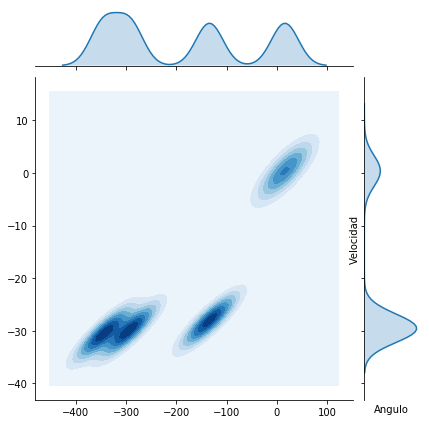

In [17]:
plot_samples=1000

ESTADOS = [0, 100 , 200 , -1]

plt.figure(dpi=300)
sample_aux_0 = np.random.multivariate_normal(np.squeeze(x_hist[ESTADOS[0],:]),P_hist[ESTADOS[0],:], size=plot_samples)
sample_aux_1 = np.random.multivariate_normal(np.squeeze(x_hist[ESTADOS[1],:]),P_hist[ESTADOS[1],:], size=plot_samples)
sample_aux_2 = np.random.multivariate_normal(np.squeeze(x_hist[ESTADOS[2],:]),P_hist[ESTADOS[2],:], size=plot_samples)
sample_aux_3 = np.random.multivariate_normal(np.squeeze(x_hist[ESTADOS[3],:]),P_hist[ESTADOS[3],:], size=plot_samples)


sample_aux = np.concatenate((np.concatenate((np.concatenate((sample_aux_0,sample_aux_1)),sample_aux_2)),sample_aux_3))
sns.jointplot(sample_aux[:,0],sample_aux[:,1] , cmap="Blues", kind="kde")
plt.ylabel('Velocidad')
plt.xlabel('Angulo')

plt.show()


# Ploteamos Resultados

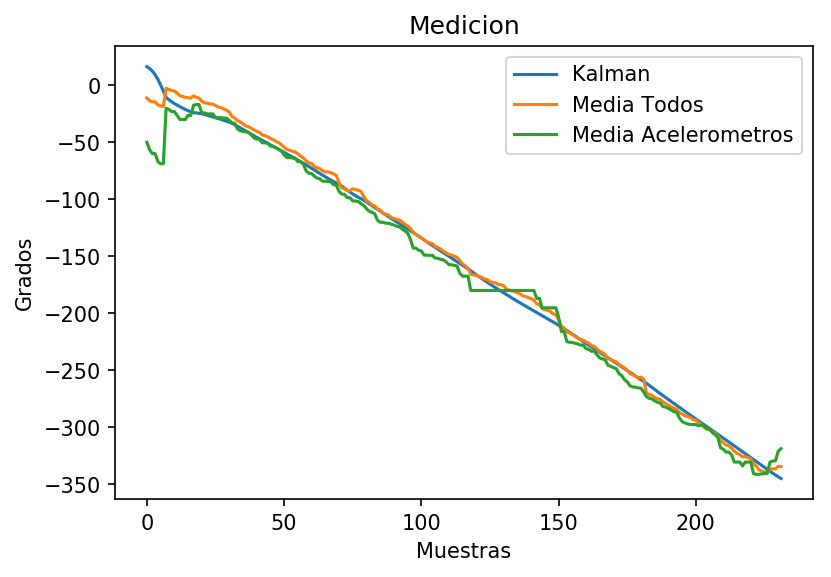

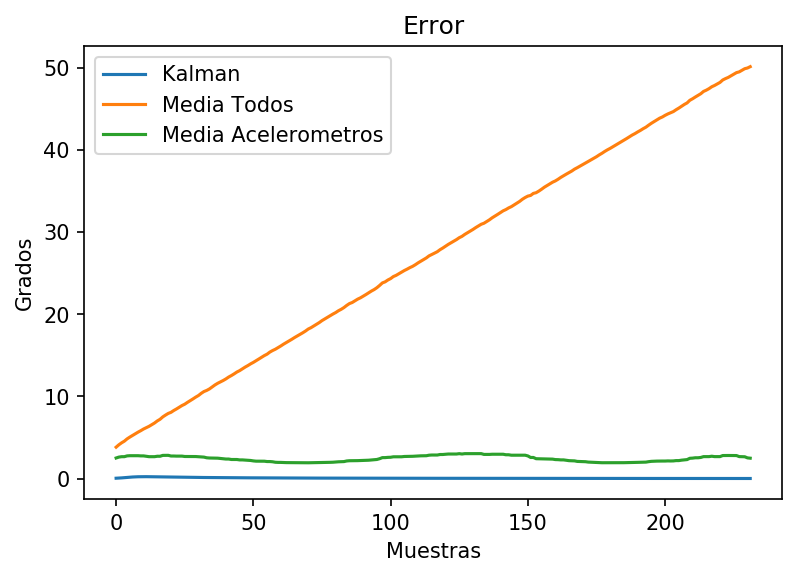

In [18]:

fig = plt.figure(dpi=150)
plt.plot(x_hist[:,0,0])
plt.plot(med_mean)
plt.plot(med_mean_acel)
plt.title('Medicion')
plt.legend(['Kalman', 'Media Todos', 'Media Acelerometros'])
plt.ylabel('Grados')
plt.xlabel('Muestras')
plt.show()

fig = plt.figure(dpi=150)
plt.plot(P_hist[:,0,0])
plt.plot(med_std_all)
plt.plot(med_std_acel)
plt.title('Error')
plt.legend(['Kalman', 'Media Todos', 'Media Acelerometros'])
plt.ylabel('Grados')
plt.xlabel('Muestras')
plt.show()
